In [14]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/projects/cft_vlm/finetune")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
import json
import re
from qwenvl.eval import comp_answer_basic, yes_no_filter, evaluate
import numpy as np


def draw_conf_mat(output_file):
  with open(output_file, "r") as f:
    items = [json.loads(line) for line in f]

  conf_mat = {
      "yes": {"yes": 0, "no": 0},
      "no": {"yes": 0, "no": 0}
  }
  invalid = {
    'yes': list(),
    'no': list()
  }
  for item in items:
    if item['answer'] not in ["yes", "no"]:
      continue
    model_answer = item.get('model_answer', '')
    model_answer = re.split(r'[^\w]+', model_answer.strip())
    model_answer = model_answer[0].lower()
    if model_answer in conf_mat:
      conf_mat[item['answer']][model_answer] += 1
    else:
      invalid[item['answer']].append(item)


  labels = ["yes", "no"]
  cm = np.array([[conf_mat["yes"]["yes"], conf_mat["yes"]["no"]],
                [conf_mat["no"]["yes"], conf_mat["no"]["no"]]])

  fig, ax = plt.subplots()
  im = ax.imshow(cm, cmap='GnBu')

  # Show all ticks and label them
  ax.set_xticks(np.arange(len(labels)), labels=labels)
  ax.set_yticks(np.arange(len(labels)), labels=labels)
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Actual")
  ax.set_title("Confusion Matrix")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
    for j in range(len(labels)):
      ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

  total = cm.sum()
  total_yes = cm[:, 0].sum()
  total_no = cm[:, 1].sum()
  print("Actual yes percentage: ", cm[0].sum() / total if total > 0 else 0)
  print("Actual no percentage: ", cm[1].sum() / total if total > 0 else 0)
  print("Model yes percentage: ", total_yes / total if total > 0 else 0)
  print("Model no percentage: ", total_no / total if total > 0 else 0)
  print("TP rate: ", cm[0, 0] / total_yes if total_yes > 0 else 0)
  print("TN rate: ", cm[1, 1] / total_no if total_no > 0 else 0)
  print("Accuracy: ", (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0)
  total_invalid = len(invalid['yes']) + len(invalid['no'])
  print("Total invalid answers: ", total_invalid)
  print("Actual yes answers with invalid model answers: ", len(invalid['yes']), len(invalid['yes']) / total_invalid if total_invalid > 0 else 0)
  print("Actual no answers with invalid model answers: ", len(invalid['no']), len(invalid['no']) / total_invalid if total_invalid > 0 else 0)
  plt.show()
  print(evaluate(output_file))
  return invalid
    

Actual yes percentage:  0.5408315883936584
Actual no percentage:  0.4591684116063416
Model yes percentage:  0.7071492671253365
Model no percentage:  0.29285073287466346
TP rate:  0.6019458544839256
TN rate:  0.6067415730337079
Accuracy:  0.6033502841758899
Total invalid answers:  18
Actual yes answers with invalid model answers:  7 0.3888888888888889
Actual no answers with invalid model answers:  11 0.6111111111111112


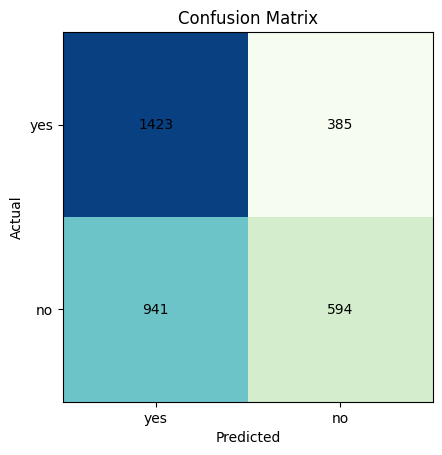

2025-06-27 09:57:51,190 - qwenvl.eval - INFO - Total: 3365, Correct: 2017, Incorrect: 1326, Invalid: 22
2025-06-27 09:57:51,191 - qwenvl.eval - INFO - Accuracy with invalid: 0.60
2025-06-27 09:57:51,191 - qwenvl.eval - INFO - Accuracy without invalid: 0.60
{'total': 3365, 'correct': 2017, 'incorrect': 1326, 'invalid': 22, 'accuracy_with_invalid': 0.5994056463595839, 'accuracy_without_invalid': 0.6033502841758899}


In [16]:
ds_name = "path_vqa"
split = "test"

def draw_conf_mat_open_pmc(ds_name, split, mode):
  if mode:
    suffix = f"-open-pmc-small-{mode}"
  else:
    suffix = ''
  output_file = f"/fs01/projects/cft_vlm/datasets/{ds_name}/results/{split}/Qwen2.5-VL-3B-Instruct{suffix}/results.jsonl"
  return draw_conf_mat(output_file)

invalid = draw_conf_mat_open_pmc(ds_name, split, "")

Actual yes percentage:  0.60149511213341
Actual no percentage:  0.39850488786659
Model yes percentage:  0.11500862564692352
Model no percentage:  0.8849913743530765
TP rate:  0.885
TN rate:  0.43534762833008445
Accuracy:  0.4870615296147211
Total invalid answers:  1622
Actual yes answers with invalid model answers:  769 0.47410604192355116
Actual no answers with invalid model answers:  853 0.5258939580764488


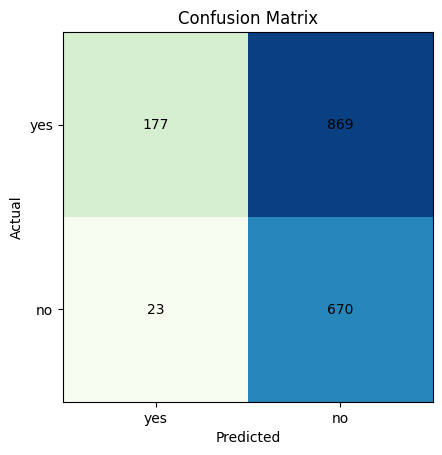

2025-06-27 09:57:51,490 - qwenvl.eval - INFO - Total: 3365, Correct: 847, Incorrect: 892, Invalid: 1626
2025-06-27 09:57:51,491 - qwenvl.eval - INFO - Accuracy with invalid: 0.25
2025-06-27 09:57:51,491 - qwenvl.eval - INFO - Accuracy without invalid: 0.49
{'total': 3365, 'correct': 847, 'incorrect': 892, 'invalid': 1626, 'accuracy_with_invalid': 0.25170876671619613, 'accuracy_without_invalid': 0.4870615296147211}


In [17]:
invalid_cpt = draw_conf_mat_open_pmc(ds_name, split, "cpt")

Actual yes percentage:  0.621172353455818
Actual no percentage:  0.378827646544182
Model yes percentage:  0.01399825021872266
Model no percentage:  0.9860017497812773
TP rate:  0.6875
TN rate:  0.3797692990239574
Accuracy:  0.38407699037620296
Total invalid answers:  2218
Actual yes answers with invalid model answers:  1105 0.4981965734896303
Actual no answers with invalid model answers:  1113 0.5018034265103697


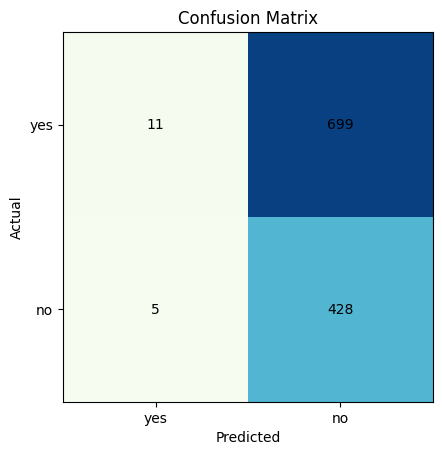

2025-06-27 09:57:51,814 - qwenvl.eval - INFO - Total: 3365, Correct: 439, Incorrect: 704, Invalid: 2222
2025-06-27 09:57:51,815 - qwenvl.eval - INFO - Accuracy with invalid: 0.13
2025-06-27 09:57:51,815 - qwenvl.eval - INFO - Accuracy without invalid: 0.38
{'total': 3365, 'correct': 439, 'incorrect': 704, 'invalid': 2222, 'accuracy_with_invalid': 0.13046062407132245, 'accuracy_without_invalid': 0.38407699037620296}


In [18]:
invalid_ift = draw_conf_mat_open_pmc(ds_name, split, "ift")

Actual yes percentage:  0.5458584576324976
Actual no percentage:  0.45414154236750237
Model yes percentage:  0.4462075531577277
Model no percentage:  0.5537924468422722
TP rate:  0.6379800853485064
TN rate:  0.5283667621776504
Accuracy:  0.5772770549032054
Total invalid answers:  210
Actual yes answers with invalid model answers:  95 0.4523809523809524
Actual no answers with invalid model answers:  115 0.5476190476190477


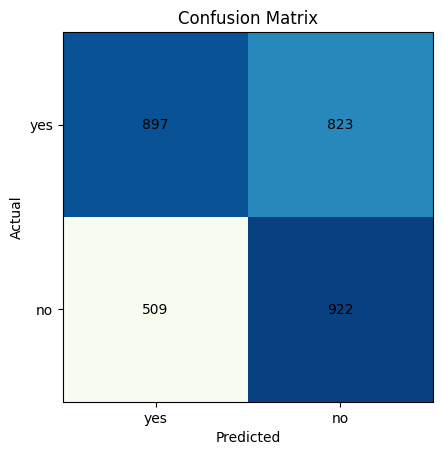

2025-06-27 09:57:52,119 - qwenvl.eval - INFO - Total: 3365, Correct: 1819, Incorrect: 1332, Invalid: 214
2025-06-27 09:57:52,120 - qwenvl.eval - INFO - Accuracy with invalid: 0.54
2025-06-27 09:57:52,121 - qwenvl.eval - INFO - Accuracy without invalid: 0.58
{'total': 3365, 'correct': 1819, 'incorrect': 1332, 'invalid': 214, 'accuracy_with_invalid': 0.5405646359583952, 'accuracy_without_invalid': 0.5772770549032054}


In [19]:
invalid_cft = draw_conf_mat_open_pmc(ds_name, split, "cft")

In [23]:
invalid_ift['yes'][0], invalid_ift['no'][0]

({'question': 'does mycobacterium avium infection in a duodenal biopsy from a patient with aids show massive intracellular macrophage infection with acid-fast organisms filamentous and pink in this acid-fast stain preparation?',
  'answer': 'yes',
  'model_answer': 'Mycobacterium avium complex (MAC) infection in a duodenal biopsy from a patient with AIDS shows massive intracellular macrophage infection with acid-fast organisms filamentous and pink in this acid-fast stain preparation. The organisms are positive for acid-fast staining, but negative for acid-fast staining with the Z'},
 {'question': 'does pbf show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei?',
  'answer': 'no',
  'model_answer': 'PBF shows branching papillae having fibrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei (H&E, 100×). PBF: papillary urothelial carcinoma; H&E: hematoxylin and eosin. Reproduced with per

In [24]:
invalid_cpt['yes'][0], invalid_cpt['no'][0]

({'question': 'does mycobacterium avium infection in a duodenal biopsy from a patient with aids show massive intracellular macrophage infection with acid-fast organisms filamentous and pink in this acid-fast stain preparation?',
  'answer': 'yes',
  'model_answer': 'The image shows a duodenal biopsy from a patient with AIDS, which demonstrates massive intracellular macrophage infection with acid-fast organisms (filamentous and pink). This is consistent with Mycobacterium avium infection. The acid-fast staining technique used here is the Ziehl-Neelsen stain. The'},
 {'question': 'does pbf show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei?',
  'answer': 'no',
  'model_answer': 'The histopathology of the right breast biopsy specimen showed a well-differentiated invasive ductal carcinoma with a cribriform pattern, which was classified as T2N0M0 (pT2a, pN0, pM0) according to the 7th edition of the American Joint Committ